In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Final Functions
parameters:
- sample size: N
- seed for randomization
- train-test split ratio

In [2]:
def get_sample(csv_file, N, seed):
    np.random.seed(seed)
    
    ratings = pd.read_csv(csv_file)
    ratings.drop(['timestamp'],axis=1,inplace=True)
    
    #keep only popular movies - number of ratings >= mean
    mean = ratings.groupby('movieId').size().mean()
    movies, m_count = np.unique(ratings['movieId'], return_counts=True)
    m_ind = movies[m_count>=mean]
    ratings = ratings[ratings['movieId'].isin(m_ind)]
    
    #sample out N users
    users, u_count = np.unique(ratings['userId'], return_counts=True)
    u_ind = np.random.choice(users, N)
    sample = ratings[ratings['userId'].isin(u_ind)]
    
    #plot data
    users_s, u_count_s = np.unique(sample['userId'], return_counts=True)
    plt.plot(np.arange(1, N+1), sorted(sample.groupby('userId').size(), reverse=True))
    plt.xlabel('number of users')
    plt.ylabel('number of rated movies')
    plt.show()
    
    print('number of unique users:', len(users_s))
    print('number of unique movies:', len(np.unique(sample['movieId'])))
    
    return sample

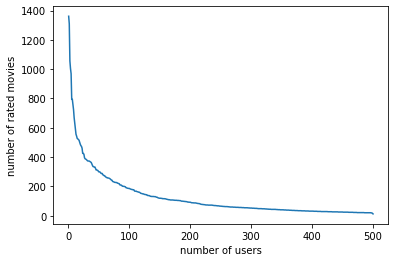

number of unique users: 500
number of unique movies: 3655


In [3]:
sample = get_sample('ratings.csv', 500, 10)

In [4]:
def get_train_test(sample_data, seed, split):
    np.random.seed(seed)
    
    #set threshold: users whose number of rated movies below threshold = into training set
    _50p = sample.groupby('userId').size().describe()[5]
    
    users, u_count = np.unique(sample['userId'], return_counts=True)
    user_train_ind = users[u_count<_50p] #into train
    user_train_ind2 = users[u_count>=_50p] #for further split
    
    #train, test split
    train1 = sample[sample['userId'].isin(user_train_ind)]
    train2, test = train_test_split(sample[sample['userId'].isin(user_train_ind2)], test_size = split)
    train = train1.append(train2)
    
    #check
    print('number of users in train:',len(np.unique(train['userId'])))
    print('number of users in test:', len(np.unique(test['userId'])))
    
    return train, test
    

In [5]:
train, test = get_train_test(sample, 10, 0.3)

number of users in train: 500
number of users in test: 251


## Process

In [6]:
ratings = pd.read_csv('ratings.csv')
ratings.drop(['timestamp'],axis=1,inplace=True)
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [7]:
ratings.shape

(20000263, 3)

In [8]:
ratings.groupby('movieId').size().describe()

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
25%          3.000000
50%         18.000000
75%        205.000000
max      67310.000000
dtype: float64

In [9]:
users, u_count = np.unique(ratings['userId'], return_counts=True)
print(len(users))
movies, m_count = np.unique(ratings['movieId'], return_counts=True)
print(len(movies))

138493
26744


In [10]:
m_ind=movies[m_count>=747.841123]
ratings2 = ratings[ratings['movieId'].isin(m_ind)]
ratings2.shape

(18230707, 3)

In [11]:
ratings2.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [12]:
users2, u_count2 = np.unique(ratings2['userId'], return_counts=True)
print(len(users2))
movies2, m_count2 = np.unique(ratings2['movieId'], return_counts=True)
print(len(movies2))

138493
3696


{'whiskers': [<matplotlib.lines.Line2D at 0x1a2075d828>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2075deb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2075d400>],
 'medians': [<matplotlib.lines.Line2D at 0x10c922588>],
 'fliers': [<matplotlib.lines.Line2D at 0x10c9228d0>],
 'means': []}

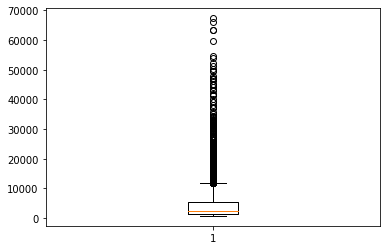

In [13]:
plt.boxplot(ratings2.groupby('movieId').size())

In [ ]:
# m_index = movies[m_count>10000]

In [14]:
np.random.seed(10)
u_ind = np.random.choice(users2,500)
sample = ratings2[ratings2['userId'].isin(u_ind)]

In [15]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63571 entries, 71779 to 19926346
Data columns (total 3 columns):
userId     63571 non-null int64
movieId    63571 non-null int64
rating     63571 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.9 MB


In [16]:
sample.head()

,userId,movieId,rating
71779,504,17,5.0
71780,504,36,4.5
71781,504,58,4.5
71782,504,111,2.5
71783,504,150,3.5


In [17]:
users3, u_count3 = np.unique(sample['userId'], return_counts=True)
print(len(users3))
movies3, m_count3 = np.unique(sample['movieId'], return_counts=True)
print(len(movies3))

500
3655


In [18]:
sample.groupby('userId').count().sort_values('movieId',ascending=False)

,movieId,rating
userId,,
94259,1361,1361
74289,1309,1309
74356,1056,1056
122310,1004,1004
38156,969,969
16785,794,794
35709,794,794
79833,755,755
31328,723,723


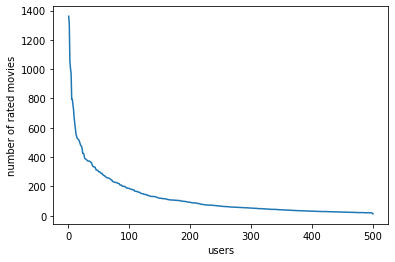

In [19]:
plt.plot(np.arange(1, len(users3)+1), sorted(sample.groupby('userId').size(), reverse=True))
plt.xlabel('users')
plt.ylabel('number of rated movies')
plt.show()

In [20]:
_50p = sample.groupby('userId').size().describe()[5]
_50p

65.0

In [21]:
print(len(users3),len(users3[u_count3<_50p]))

500 249


In [22]:
user_train_ind = users3[u_count3<_50p]
user_train_ind2 = users3[u_count3>=_50p]
train1 = sample[sample['userId'].isin(user_train_ind)]

In [23]:
train1

,userId,movieId,rating
348931,2355,6,4.0
348932,2355,16,3.0
348933,2355,21,4.0
348934,2355,25,4.0
348935,2355,32,5.0
348936,2355,47,5.0
348937,2355,50,5.0
348938,2355,58,3.0
348939,2355,76,2.0
348940,2355,95,3.0


In [24]:
train2, test = train_test_split(sample[sample['userId'].isin(user_train_ind2)], test_size = 0.3)

In [25]:
train = train1.append(train2)

In [26]:
train

,userId,movieId,rating
348931,2355,6,4.0
348932,2355,16,3.0
348933,2355,21,4.0
348934,2355,25,4.0
348935,2355,32,5.0
348936,2355,47,5.0
348937,2355,50,5.0
348938,2355,58,3.0
348939,2355,76,2.0
348940,2355,95,3.0


In [27]:
test

,userId,movieId,rating
10746443,74289,30816,4.0
3342309,22860,474,4.0
11363366,78451,4446,3.0
12513856,86472,151,4.0
12292907,84903,1916,3.0
17268768,119430,1884,2.5
3181925,21718,1200,5.0
18442287,127671,1148,5.0
4575941,31328,2167,3.0
248258,1722,2096,5.0


In [28]:
print(len(np.unique(train['userId'])), len(np.unique(test['userId'])))

500 251
